# 混合高斯模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# 生成男女生身高样本
girl_num = 15000
boy_num = 10000
girl_mean = 160
boy_mean = 170
girl_std = 6
boy_std = 5

boy_hight = np.random.normal(size = boy_num) * boy_std + boy_mean
girl_hight = np.random.normal(size = girl_num) * girl_std + girl_mean

boy_df = pd.DataFrame(boy_hight,columns=['hight'])
boy_df['gender'] = 'B'
boy_df['R_Q_1'] = 1.

girl_df = pd.DataFrame(girl_hight,columns=['hight'])
girl_df['gender'] = 'G'
girl_df['R_Q_0'] = 1.

mix_df = boy_df.append(girl_df)
mix_df.fillna(0., inplace=True)

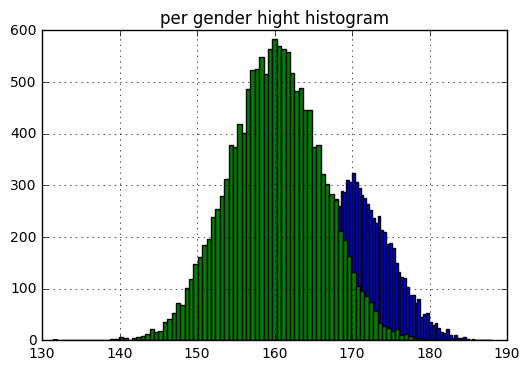

In [3]:
# 分性别频度图可以看出男女各自服从自己的正态分布
mix_df.groupby('gender').hight.hist(bins = 100)
plt.title('per gender hight histogram')
plt.show()

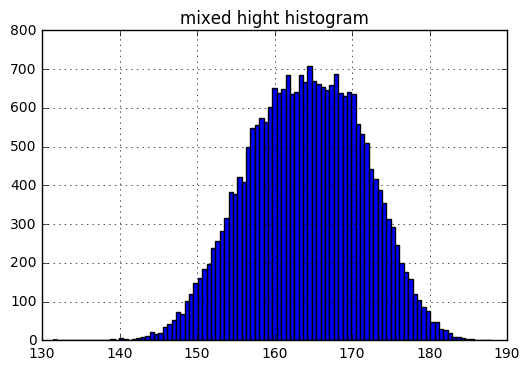

In [4]:
# 混合身高频度图中可以看到男女平均值附近各有一个高峰
mix_df.hight.hist(bins = 100)
plt.title('mixed hight histogram')
plt.show()

In [19]:
#混合高斯模型的目的就是从混合频度图还原到分性别的频度图，我们采取EM algorithem

def gaussian(x,m,s):
    return 1/(np.sqrt(2*np.pi)*s)*np.e**(-0.5*(float(x-m)/s)**2)

def unit_gaussian(x):
    return 1/(np.sqrt(2*np.pi))*np.e**(-0.5*(float(x))**2)

def E_step(mix_df, tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1):
    mix_df['l_0'] = ((mix_df.hight - mu_0)*(sigma_0)**(-1)).apply(unit_gaussian)*(sigma_0)**(-1)*tau_0
    mix_df['l_1'] = ((mix_df.hight - mu_1)*(sigma_1)**(-1)).apply(unit_gaussian)*(sigma_1)**(-1)*tau_1
    mix_df['Q_0'] = mix_df['l_0'] * (mix_df['l_0'] + mix_df['l_1'])**(-1)
    mix_df['Q_1'] = mix_df['l_1'] * (mix_df['l_0'] + mix_df['l_1'])**(-1)
    mix_df['predict_gender'] = mix_df['Q_0'].apply(lambda x:'G' if x>0.5 else 'B' if x<0.5 else 'BG')
    return mix_df

def M_step(mix_df, tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1):
    tau_0 = mix_df.Q_0.mean()
    tau_1 = mix_df.Q_1.mean()
    mu_0 = (mix_df.hight * mix_df.Q_0).sum() * mix_df.Q_0.sum()**(-1)
    mu_1 = (mix_df.hight * mix_df.Q_1).sum() * mix_df.Q_1.sum()**(-1)
    sigma_0 = np.sqrt((mix_df.hight - mu_0).T.dot((mix_df.hight - mu_0)*mix_df.Q_0) * mix_df.Q_0.sum()**(-1))
    sigma_1 = np.sqrt((mix_df.hight - mu_1).T.dot((mix_df.hight - mu_0)*mix_df.Q_1) * mix_df.Q_1.sum()**(-1))
    return tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1


In [21]:
# 利用混合样本对两个模型分别进行初始化
tau_0  = 0.5
tau_1  = 0.5
mu_0   = mix_df.hight.min()
mu_1   = mix_df.hight.max()
#mu_0 = 164
#mu_1 = 166
sigma_0= mix_df.hight.std()
sigma_1= mix_df.hight.std()

mix_df['Q_0'] = 0.5
mix_df['Q_1'] = 0.5

mix_df['predict_gender'] = 'BG'

for parameter in ['tau_0','tau_1','mu_0','mu_1','sigma_0','sigma_1']:
    print '    %s:%.2f'%(parameter,eval(parameter))

     tau_0:0.50
    tau_1:0.50
    mu_0:136.52
    mu_1:189.31
    sigma_0:7.44
    sigma_1:7.44


In [22]:
# 交替进行E步骤和M步骤
for step_ind in range(1,602):
    if step_ind == 1:
        print "parameters start from:"
        for parameter in ['tau_0','tau_1','mu_0','mu_1','sigma_0','sigma_1']:
            print '%s:%.2f, '%(parameter,eval(parameter)),
#        mix_df.groupby('gender').Q_1.hist(bins=100)
#        plt.show()
#        print "False ratio: %.2f"%(len(mix_df.loc[mix_df.gender!=mix_df.predict_gender])*1./len(mix_df))
#        mix_df.groupby('gender').hight.hist(bins=100)
#        plt.show()

    mix_df = E_step(mix_df, tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1)
    tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1 = M_step(mix_df, tau_0, tau_1, mu_0, mu_1, sigma_0, sigma_1)
    if step_ind%50 == 1:
        print
        print "STEP%d: parameter update"%step_ind
        for parameter in ['tau_0','tau_1','mu_0','mu_1','sigma_0','sigma_1']:
            print '%s:%.2f, '%(parameter,eval(parameter)),
#        print "gender grouping effect"
#        mix_df.groupby('gender').Q_1.hist(bins=100)
#        plt.show()
#        print "False ratio   : %.2f"%(len(mix_df.loc[mix_df.gender!=mix_df.predict_gender])*1./len(mix_df))
#        print "Boy prob corr : %.2f"%(mix_df.loc[:,['Q_1','R_Q_1']].corr()['Q_1']['R_Q_1'])
#        print "Girl prob corr: %.2f"%(mix_df.loc[:,['Q_0','R_Q_0']].corr()['Q_0']['R_Q_0'])
        
#        mix_df.groupby('predict_gender').hight.hist(bins=100)
#        plt.show()



parameters start from:
tau_0:0.50,  tau_1:0.50,  mu_0:136.52,  mu_1:189.31,  sigma_0:7.44,  sigma_1:7.44, 
STEP1: parameter update
tau_0:0.44,  tau_1:0.56,  mu_0:157.38,  mu_1:169.30,  sigma_0:4.42,  sigma_1:4.59, 
STEP51: parameter update
tau_0:0.47,  tau_1:0.53,  mu_0:158.64,  mu_1:168.77,  sigma_0:5.54,  sigma_1:5.39, 
STEP101: parameter update
tau_0:0.49,  tau_1:0.51,  mu_0:158.89,  mu_1:169.00,  sigma_0:5.62,  sigma_1:5.30, 
STEP151: parameter update
tau_0:0.51,  tau_1:0.49,  mu_0:159.11,  mu_1:169.20,  sigma_0:5.69,  sigma_1:5.23, 
STEP201: parameter update
tau_0:0.53,  tau_1:0.47,  mu_0:159.31,  mu_1:169.38,  sigma_0:5.75,  sigma_1:5.17, 
STEP251: parameter update
tau_0:0.55,  tau_1:0.45,  mu_0:159.47,  mu_1:169.53,  sigma_0:5.81,  sigma_1:5.12, 
STEP301: parameter update
tau_0:0.56,  tau_1:0.44,  mu_0:159.62,  mu_1:169.66,  sigma_0:5.86,  sigma_1:5.08, 
STEP351: parameter update
tau_0:0.57,  tau_1:0.43,  mu_0:159.74,  mu_1:169.78,  sigma_0:5.90,  sigma_1:5.04, 
STEP401: paramet

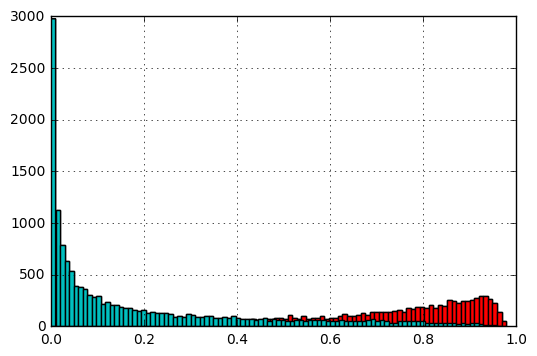

In [24]:
mix_df.groupby('gender').Q_1.hist(bins=100)
plt.show()

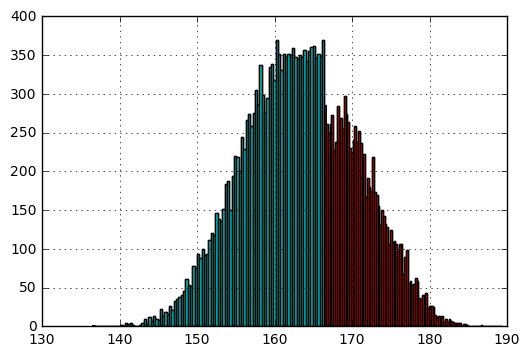

In [26]:
mix_df.groupby('predict_gender').hight.hist(bins=100)
plt.show()